# Build Models and Analyse FD001

In [84]:
import os
os.environ["KERAS_BACKEND"] = "torch"
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"  # optional: reduce MPS memory pressure

from keras.models import load_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
from keras.models import load_model as keras_load_model
import random
from typing import Iterable, Dict, List, Optional, Tuple

In [85]:
# --- functions---

def load_any_model(path):
    """
    Load a model given its file path, handling both Keras (.keras/.h5) and joblib (.joblib/.pkl).
    """
    path = Path(path)
    suf = path.suffix.lower()
    if suf in {".keras", ".h5", ".hdf5"}:
        return keras_load_model(path)
    if suf in {".joblib", ".pkl"}:
        return joblib.load(path)
    raise ValueError(f"Unrecognized model suffix for {path.name}")

def load_models(model_paths: dict):
    """
    model_paths: dict like {"Base": "...joblib", "LSTM": "...keras", "CNN": "...keras", "CNN-LSTM": "...keras"}
    returns: dict {name: model_object}
    """
    models = {}
    for name, path in model_paths.items():
        models[name] = load_any_model(path)
    return models

def build_model_paths(dataset=None, seq_len=None, strategy="last", art_dir=None,
                      include=("Base", "LSTM", "CNN", "CNN-LSTM")):
    """
    Build default file paths for your saved models in <ART_DIR>/models/…
    Base:      base_linear_{dataset.lower()}_seq{seq_len}_{strategy}.joblib
    LSTM:      lstm_{dataset.lower()}_seq{seq_len}.keras
    CNN:       cnn_{dataset.lower()}_seq{seq_len}.keras
    CNN-LSTM:  cnn_lstm_{dataset.lower()}_seq{seq_len}.keras
    """
    if dataset is None:
        dataset = globals().get("DATASET", "FD001")
    if seq_len is None:
        seq_len = globals().get("SEQ_LEN", 30)
    if art_dir is None:
        art_dir = globals().get("ART_DIR", Path.cwd() / f"{dataset} data & artefacts")

    models_dir = Path(art_dir) / "models"
    ds = dataset.lower()

    paths = {}
    if "Base" in include:
        paths["Base"] = str(models_dir / f"base_linear_{ds}_seq{seq_len}_{strategy}.joblib")
    if "LSTM" in include:
        paths["LSTM"] = str(models_dir / f"lstm_{ds}_seq{seq_len}.keras")
    if "CNN" in include:
        paths["CNN"] = str(models_dir / f"cnn_{ds}_seq{seq_len}.keras")
    if "CNN-LSTM" in include:
        paths["CNN-LSTM"] = str(models_dir / f"cnn_lstm_{ds}_seq{seq_len}.keras")
    return paths


def plot_true_vs_pred(y_true, y_pred, model_name="Model", savepath=None):
    """
    Scatter plot: True RUL vs Predicted RUL for a single model.
    
    Args:
        y_true (array-like): Ground truth RUL values.
        y_pred (array-like): Predicted RUL values.
        model_name (str): Name of the model for labeling.
        savepath (str or None): If given, save the figure to this path.
    """
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.6, edgecolor="k")
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([0, max_val], [0, max_val], "r--", lw=2, label="Ideal")
    plt.xlabel("True RUL")
    plt.ylabel("Predicted RUL")
    plt.title(f"True vs Predicted RUL ({model_name})")
    plt.legend()
    plt.grid(True)
    if savepath:
        plt.savefig(savepath, dpi=300, bbox_inches="tight")
    plt.show()



def plot_residuals(y_true, y_pred, model_name="Model", kind="box", savepath=None):
    """
    Plot residuals (Predicted - True) for a single model.
    
    Args:
        y_true (array-like): Ground truth RUL values.
        y_pred (array-like): Predicted RUL values.
        model_name (str): Label for the model.
        kind (str): "box" or "violin" for plot type.
        savepath (str or None): If given, save the figure.
    """
    errors = y_pred - y_true
    plt.figure(figsize=(6, 4))
    
    if kind == "violin":
        sns.violinplot(y=errors)
    else:
        sns.boxplot(y=errors)
    
    plt.axhline(0, color="r", linestyle="--", lw=2, label="Zero Error")
    plt.ylabel("Residual (Predicted - True)")
    plt.title(f"Residual Distribution ({model_name})")
    plt.legend()
    plt.grid(True, axis="y")
    if savepath:
        plt.savefig(savepath, dpi=300, bbox_inches="tight")
    plt.show()

def plot_per_engine_bars(y_true, y_pred, unit_ids, model_name="Model", n_samples=30, savepath=None, seed=42):
    """
    Bar plot comparing Actual vs Predicted RUL for a random sample of engines.
    
    Args:
        y_true (array-like): Ground truth RUL values (aligned with unit_ids).
        y_pred (array-like): Predicted RUL values (aligned with unit_ids).
        unit_ids (array-like): Engine/unit identifiers for each sample.
        model_name (str): Name of the model for labeling.
        n_samples (int): Number of engines to randomly sample.
        savepath (str or None): If given, save the figure.
        seed (int): Random seed for reproducibility.
    """
    random.seed(seed)
    unique_ids = np.unique(unit_ids)
    chosen_ids = random.sample(list(unique_ids), min(n_samples, len(unique_ids)))

    # Collect true & pred for chosen engines
    true_sample, pred_sample, labels = [], [], []
    for uid in chosen_ids:
        mask = unit_ids == uid
        # last entry corresponds to the test RUL label
        true_sample.append(y_true[mask][-1])
        pred_sample.append(y_pred[mask][-1])
        labels.append(str(uid))

    x = np.arange(len(chosen_ids))
    width = 0.35

    plt.figure(figsize=(12, 6))
    plt.bar(x - width/2, true_sample, width, label="Actual")
    plt.bar(x + width/2, pred_sample, width, label="Predicted")
    plt.xticks(x, labels, rotation=45)
    plt.xlabel("Engine ID (sampled)")
    plt.ylabel("RUL")
    plt.title(f"Actual vs Predicted RUL (Sampled Engines) - {model_name}")
    plt.legend()
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=300, bbox_inches="tight")
    plt.show()
def plot_metric_comparison(metrics_list,
                           dataset_name: str = "FD001",
                           savepath: Optional[str] = None):
    """
    Grouped bar chart of RMSE/MAE across models.
    Accepts either:
      - list of dicts: [{"model":"LSTM","RMSE":15.2,"MAE":11.3}, ...]
      - DataFrame with columns: model/Model, RMSE, MAE
    """
    # Build DataFrame
    df = metrics_list.copy() if isinstance(metrics_list, pd.DataFrame) else pd.DataFrame(metrics_list)
    if df.empty:
        print("No metrics to plot.")
        return

    # Normalise column names
    if "model" not in df.columns and "Model" in df.columns:
        df = df.rename(columns={"Model": "model"})

    # Validate required columns
    required = {"model", "RMSE", "MAE"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing columns for plotting: {missing}")

    # Keep only what we need, coerce to numeric
    df = df[["model", "RMSE", "MAE"]].copy()
    df[["RMSE", "MAE"]] = df[["RMSE", "MAE"]].astype(float)
    df = df.set_index("model")

    # Plot
    ax = df.plot(kind="bar", figsize=(10, 6))
    ax.set_title(f"RMSE / MAE Comparison — {dataset_name}")
    ax.set_ylabel("Error")
    ax.set_xlabel("")
    ax.grid(True, axis="y", alpha=0.3)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

 # Project Module and base set up

In [86]:
# Project modules
import data_loader as dl
import pre_processing as pp
import evaluator as ev
import base_model as base
import lstm_model as lstm
import cnn_model as cnn
import cnn_lstm_model as cnnlstm
import plots

# ---- Paths ----
ROOT = Path.cwd()
CMAPS = ROOT / "CMaps"  # keep correct folder case
# ==== Minimal config you tweak next time ====
DATASET = "FD001"       # <— change this to FD002/FD003/FD004 later
SEQ_LEN = 30            # sliding window
MAX_RUL = 130           # RUL clipping
VAL_SPLIT = 0.30        # val split by unit

# Files derived from DATASET (so you edit one line only)
TRAIN_PATH = CMAPS / f"train_{DATASET}.txt"
TEST_PATH  = CMAPS / f"test_{DATASET}.txt"
RUL_PATH   = CMAPS / f"RUL_{DATASET}.txt"

# Artifacts folder for this dataset
ART_DIR = ROOT / f"{DATASET} data & artefacts"
ART_DIR.mkdir(exist_ok=True)

print(f"backend: torch | dataset: {DATASET}")
print("Train:", TRAIN_PATH.name, "| Test:", TEST_PATH.name, "| RUL:", RUL_PATH.name)

backend: torch | dataset: FD001
Train: train_FD001.txt | Test: test_FD001.txt | RUL: RUL_FD001.txt


 # Load & Preprocessing Data

Loaded.
  train_df: (20631, 26)   test_df: (13096, 26)   rul_df: (100, 1)
Shape: (20631, 26)

Unique engines: 100

Missing values:
 0

Max cycles per engine:
count    100.000000
mean     206.310000
std       46.342749
min      128.000000
25%      177.000000
50%      199.000000
75%      229.250000
max      362.000000
Name: time_in_cycles, dtype: float64

First 5 rows:


,unit_number,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


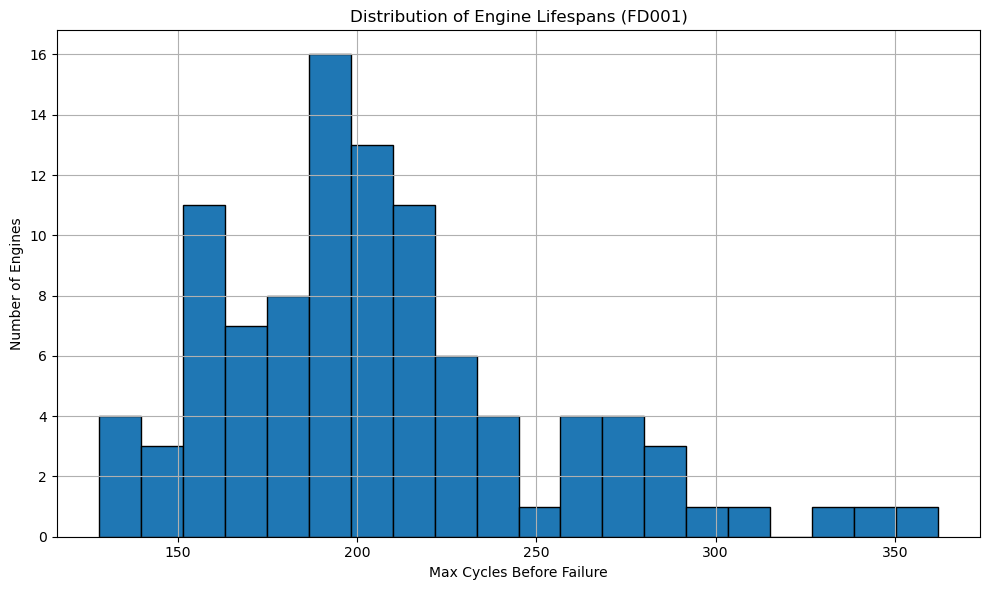

Dataset: FD001
Mean cycles to failure: 206.31
Standard deviation: 46.34
Minimum: 128
Maximum: 362
After preprocessing (FD001, no new pp funcs):
  Train engines : 80
  Val engines   : 20
  X_train shape : (14241, 30, 15)  y_train: (14241,)
  X_val   shape : (3490, 30, 15)  y_val  : (3490,)
  X_test  shape : (10196, 30, 15)  y_test : (10196,)
  Dropped sensors: ['sensor_measurement_1', 'sensor_measurement_5', 'sensor_measurement_10', 'sensor_measurement_16', 'sensor_measurement_18', 'sensor_measurement_19']
Data saved to C:\Users\mg020649\Documents\15 - Coding\Msc-Project-main\FD001 data & artefacts\fd001_seq30.npz


In [87]:
# --- Load FD001 ---
train_df = dl.load_raw_data(CMAPS / f"train_{DATASET}.txt")
test_df, rul_df = dl.load_test_data(
    CMAPS / f"test_{DATASET}.txt",
    CMAPS / f"RUL_{DATASET}.txt"
)

unit_ids = test_df["unit_number"].values

print("Loaded.")
print("  train_df:", train_df.shape, "  test_df:", test_df.shape, "  rul_df:", rul_df.shape)
assert train_df.shape[1] == 26 and test_df.shape[1] == 26

dl.inspect_data(train_df)
pp.summarise_engine_lifespans(train_df, dataset_name=DATASET)

# ---------------------------
# 1) TRAIN: make targets first (no leakage)
# ---------------------------
train_rul = pp.calculate_rul(train_df, max_rul=MAX_RUL)

# ---------------------------
# 2) Split by unit BEFORE deciding features/scaling
# ---------------------------
train_split, val_split = pp.split_by_unit(train_rul, test_size=0.2, random_state=42)

# ---------------------------
# 3) Decide flat sensors using TRAIN ONLY, then drop same cols from val/test
# ---------------------------
before_cols = list(train_split.columns)
train_split_clean = pp.drop_flat_sensors(train_split.copy())
after_cols  = list(train_split_clean.columns)
dropped_cols = [c for c in before_cols if c not in after_cols]

val_split_clean = val_split.drop(columns=[c for c in dropped_cols if c in val_split.columns]).reset_index(drop=True)
test_df_clean   = test_df.drop(columns=[c for c in dropped_cols if c in test_df.columns]).reset_index(drop=True)

# ---------------------------
# 4) TEST: build true RUL from RUL file, then clip like train
# ---------------------------
last_cycles = test_df_clean.groupby("unit_number")["time_in_cycles"].max()
rul_map = dict(zip(sorted(test_df_clean["unit_number"].unique()), rul_df["RUL"].values))
test_df_clean = test_df_clean.copy()
test_df_clean["RUL"] = test_df_clean.apply(
    lambda r: (last_cycles.loc[r["unit_number"]] - r["time_in_cycles"]) + rul_map[r["unit_number"]],
    axis=1
)
test_df_clean["RUL"] = np.minimum(test_df_clean["RUL"], MAX_RUL)

# ---------------------------
# 5) Scale sensors with ONE scaler fit on TRAIN ONLY (FD001 = single condition)
#    (avoid standardise_per_condition here to prevent re-fitting on val/test)
# ---------------------------
from sklearn.preprocessing import StandardScaler

sensor_cols = [c for c in train_split_clean.columns if c.startswith("sensor_measurement")]
scaler = StandardScaler().fit(train_split_clean[sensor_cols])

train_scaled = train_split_clean.copy()
val_scaled   = val_split_clean.copy()
test_scaled  = test_df_clean.copy()

train_scaled[sensor_cols] = scaler.transform(train_scaled[sensor_cols])
val_scaled[sensor_cols]   = scaler.transform(val_scaled[sensor_cols])
test_scaled[sensor_cols]  = scaler.transform(test_scaled[sensor_cols])

# ---------------------------
# 6) Windowing with your helper
# ---------------------------
X_train, y_train = pp.generate_sliding_windows(train_scaled, seq_len=SEQ_LEN)
X_val,   y_val   = pp.generate_sliding_windows(val_scaled,   seq_len=SEQ_LEN)
X_test,  y_test  = pp.generate_sliding_windows(test_scaled,  seq_len=SEQ_LEN)

print("After preprocessing (FD001, no new pp funcs):")
print("  Train engines :", train_scaled['unit_number'].nunique())
print("  Val engines   :",   val_scaled['unit_number'].nunique())
print("  X_train shape :", X_train.shape, " y_train:", y_train.shape)
print("  X_val   shape :", X_val.shape,   " y_val  :", y_val.shape)
print("  X_test  shape :", X_test.shape,  " y_test :", y_test.shape)
print("  Dropped sensors:", dropped_cols)

# --- Save to use in model ---
out_npz = ART_DIR / f"{DATASET.lower()}_seq{SEQ_LEN}.npz"
pp.save_preprocessed_data(X_train, y_train, X_val, y_val, X_test, y_test, filename=str(out_npz))


 # =====================Train Models======================

 ## Base Model

In [88]:
from base_model import train_linear_model

# 1) Load cached windows
npz_path = ART_DIR / f"{DATASET.lower()}_seq{SEQ_LEN}.npz"
X_train, y_train, X_val, y_val, X_test, y_test = pp.load_preprocessed_data(str(npz_path))

# 2) Convert 3D windows -> 2D feature vectors for baseline
#    (stick to your existing helper; default strategy='last')
X_train_feat = pp.make_feature_vectors_from_windows(X_train, strategy='last')
X_val_feat   = pp.make_feature_vectors_from_windows(X_val,   strategy='last')

print("Feature shapes (base model):")
print("  X_train:", X_train_feat.shape, " y_train:", y_train.shape)
print("  X_val  :", X_val_feat.shape,   " y_val  :", y_val.shape)

# 3) Train simple Linear Regression
base_model = train_linear_model(X_train_feat, y_train)

# 4) Save the trained model
models_dir = ART_DIR / "models"
models_dir.mkdir(parents=True, exist_ok=True)

model_path = models_dir / f"base_linear_{DATASET.lower()}_seq{SEQ_LEN}_last.joblib"
joblib.dump(base_model, model_path)

print("Saved base model to:", model_path)

Feature shapes (base model):
  X_train: (14241, 15)  y_train: (14241,)
  X_val  : (3490, 15)  y_val  : (3490,)
Saved base model to: C:\Users\mg020649\Documents\15 - Coding\Msc-Project-main\FD001 data & artefacts\models\base_linear_fd001_seq30_last.joblib


# CNN Model

In [89]:
# --- Train / Save: CNN (FD001) ---

from cnn_model import build_cnn_model, train_cnn_model
import json

# 1) Load cached 3D windows
npz_path = ART_DIR / f"{DATASET.lower()}_seq{SEQ_LEN}.npz"
X_train, y_train, X_val, y_val, X_test, y_test = pp.load_preprocessed_data(str(npz_path))

# 2) Build CNN
input_shape = (SEQ_LEN, X_train.shape[2])
cnn = build_cnn_model(input_shape)

# 3) Train (only pass what your module expects!)
cnn, history = train_cnn_model(cnn, X_train, y_train, X_val, y_val, epochs=30, batch_size=128)

# 4) Save model + meta
models_dir = ART_DIR / "models"
models_dir.mkdir(parents=True, exist_ok=True)
model_path = models_dir / f"cnn_{DATASET.lower()}_seq{SEQ_LEN}.keras"
cnn.save(model_path)

meta = {
    "model_type": "cnn",
    "dataset": DATASET,
    "seq_len": int(SEQ_LEN),
    "features": int(X_train.shape[2]),
    "epochs": 30,
    "batch_size": 128
}
with open(models_dir / f"cnn_{DATASET.lower()}_seq{SEQ_LEN}.meta.json", "w") as f:
    json.dump(meta, f, indent=2)

print("Saved CNN model to:", model_path)

Epoch 1/30
112/112 [==============================] - 1s 9ms/step - loss: 2430.6372 - val_loss: 545.6964
Epoch 2/30
112/112 [==============================] - 1s 10ms/step - loss: 746.0840 - val_loss: 514.2057
Epoch 3/30
112/112 [==============================] - 1s 9ms/step - loss: 680.1778 - val_loss: 475.8336
Epoch 4/30
112/112 [==============================] - 1s 10ms/step - loss: 587.3165 - val_loss: 406.2617
Epoch 5/30
112/112 [==============================] - 1s 9ms/step - loss: 529.3652 - val_loss: 392.8668
Epoch 6/30
112/112 [==============================] - 1s 8ms/step - loss: 475.4832 - val_loss: 355.6811
Epoch 7/30
112/112 [==============================] - 1s 8ms/step - loss: 416.3690 - val_loss: 341.5238
Epoch 8/30
112/112 [==============================] - 1s 8ms/step - loss: 354.3781 - val_loss: 303.2555
Epoch 9/30
112/112 [==============================] - 1s 8ms/step - loss: 317.3850 - val_loss: 287.6030
Epoch 10/30
112/112 [==============================] - 1s 8ms

 # LSTM MODEL

In [90]:
# --- LSTM model (train + save) ---

from lstm_model import build_lstm_model, train_lstm_model
import json

# 1) Load cached 3D windows
npz_path = ART_DIR / f"{DATASET.lower()}_seq{SEQ_LEN}.npz"
X_train, y_train, X_val, y_val, X_test, y_test = pp.load_preprocessed_data(str(npz_path))

# 2) Build LSTM (input: [seq_len, n_features])
input_shape = (SEQ_LEN, X_train.shape[2])
lstm = build_lstm_model(input_shape)

# 3) Train (pass only what your module expects)
#    If your train_lstm_model returns (model, history), keep both; if it returns only model, handle that too.
result = train_lstm_model(lstm, X_train, y_train, X_val, y_val, epochs=50, batch_size=128)
if isinstance(result, tuple):
    lstm, lstm_history = result
else:
    lstm = result
    lstm_history = None

# 4) Save model + minimal metadata
models_dir = ART_DIR / "models"
models_dir.mkdir(parents=True, exist_ok=True)

model_path = models_dir / f"lstm_{DATASET.lower()}_seq{SEQ_LEN}.keras"
lstm.save(model_path)

meta = {
    "model_type": "lstm",
    "dataset": DATASET,
    "seq_len": int(SEQ_LEN),
    "features": int(X_train.shape[2]),
    "epochs": 50,
    "batch_size": 128
}
with open(models_dir / f"lstm_{DATASET.lower()}_seq{SEQ_LEN}.meta.json", "w") as f:
    json.dump(meta, f, indent=2)

print("Saved LSTM model to:", model_path)

Epoch 1/50
112/112 [==============================] - 7s 41ms/step - loss: 7562.5532 - val_loss: 6861.7861
Epoch 2/50
112/112 [==============================] - 4s 35ms/step - loss: 6730.3076 - val_loss: 6315.0210
Epoch 3/50
112/112 [==============================] - 4s 35ms/step - loss: 6208.6411 - val_loss: 5828.0205
Epoch 4/50
112/112 [==============================] - 4s 36ms/step - loss: 5739.6802 - val_loss: 5387.2583
Epoch 5/50
112/112 [==============================] - 4s 35ms/step - loss: 5312.0806 - val_loss: 4980.8403
Epoch 6/50
112/112 [==============================] - 4s 38ms/step - loss: 4915.9985 - val_loss: 4604.2236
Epoch 7/50
112/112 [==============================] - 4s 35ms/step - loss: 4547.2300 - val_loss: 4253.5591
Epoch 8/50
112/112 [==============================] - 4s 34ms/step - loss: 4196.9419 - val_loss: 3928.9534
Epoch 9/50
112/112 [==============================] - 4s 34ms/step - loss: 3887.3967 - val_loss: 3628.5186
Epoch 10/50
112/112 [================

#  CNN_LSTM Model

In [91]:
# --- CNN-LSTM model (train + save) ---

from cnn_lstm_model import build_cnn_lstm_model, train_cnn_lstm_model
import json

# 1) Load cached 3D windows
npz_path = ART_DIR / f"{DATASET.lower()}_seq{SEQ_LEN}.npz"
X_train, y_train, X_val, y_val, X_test, y_test = pp.load_preprocessed_data(str(npz_path))

# 2) Build model (input: [seq_len, n_features])
input_shape = (SEQ_LEN, X_train.shape[2])
cnnlstm = build_cnn_lstm_model(input_shape)

# 3) Train (handle: returns History, returns Model, or returns (Model, History))
train_ret = train_cnn_lstm_model(
    cnnlstm, X_train, y_train, X_val, y_val,
    epochs=50, batch_size=128
)

# Normalize outputs
cnnlstm_history = None
model_to_save = cnnlstm  # fallback: the model we built

# Case A: (model, history)
if isinstance(train_ret, tuple) and len(train_ret) >= 1:
    if hasattr(train_ret[0], "save"):
        model_to_save = train_ret[0]
    if len(train_ret) >= 2 and hasattr(train_ret[1], "history"):
        cnnlstm_history = train_ret[1]

# Case B: just a model
elif hasattr(train_ret, "save"):
    model_to_save = train_ret

# Case C: just a History
elif hasattr(train_ret, "history"):
    cnnlstm_history = train_ret

# 4) Save model + minimal metadata
models_dir = ART_DIR / "models"
models_dir.mkdir(parents=True, exist_ok=True)

model_path = models_dir / f"cnn_lstm_{DATASET.lower()}_seq{SEQ_LEN}.keras"
model_to_save.save(model_path)

meta = {
    "model_type": "cnn_lstm",
    "dataset": DATASET,
    "seq_len": int(SEQ_LEN),
    "features": int(X_train.shape[2]),
    "epochs": 50,          # keep in sync with your fit(...)
    "batch_size": 128      # keep in sync with your fit(...)
}
with open(models_dir / f"cnn_lstm_{DATASET.lower()}_seq{SEQ_LEN}.meta.json", "w") as f:
    json.dump(meta, f, indent=2)

# (Optional) persist training history if available
if cnnlstm_history:
    hist_path = models_dir / f"cnn_lstm_{DATASET.lower()}_seq{SEQ_LEN}.history.json"
    with open(hist_path, "w") as f:
        json.dump(cnnlstm_history.history, f, indent=2)


print("Saved CNN-LSTM model to:", model_path)

Epoch 1/50
112/112 [==============================] - 6s 32ms/step - loss: 5221.5181 - mae: 60.3353 - val_loss: 2435.6050 - val_mae: 40.1090
Epoch 2/50
112/112 [==============================] - 3s 29ms/step - loss: 1291.7435 - mae: 28.2668 - val_loss: 657.3648 - val_mae: 22.8221
Epoch 3/50
112/112 [==============================] - 3s 29ms/step - loss: 599.5092 - mae: 18.9909 - val_loss: 405.6673 - val_mae: 17.2569
Epoch 4/50
112/112 [==============================] - 3s 30ms/step - loss: 452.6629 - mae: 16.1052 - val_loss: 274.5971 - val_mae: 13.1704
Epoch 5/50
112/112 [==============================] - 3s 29ms/step - loss: 376.0709 - mae: 14.6896 - val_loss: 293.0319 - val_mae: 12.5061
Epoch 6/50
112/112 [==============================] - 3s 29ms/step - loss: 319.1649 - mae: 13.4552 - val_loss: 299.3013 - val_mae: 13.9737
Epoch 7/50
112/112 [==============================] - 3s 29ms/step - loss: 298.9593 - mae: 13.0250 - val_loss: 328.6744 - val_mae: 14.2838
Epoch 8/50
112/112 [====

# =================== End of Training ====================

# ================== Model Analysis =====================

# LOAD MODEL

In [92]:
# LOAD baseline MODEL
model_paths = build_model_paths()  # will only load what exists
print("Will load:", model_paths)

models = load_models(model_paths)
print("Loaded models:", list(models.keys()))

Will load: {'Base': 'C:\\Users\\mg020649\\Documents\\15 - Coding\\Msc-Project-main\\FD001 data & artefacts\\models\\base_linear_fd001_seq30_last.joblib', 'LSTM': 'C:\\Users\\mg020649\\Documents\\15 - Coding\\Msc-Project-main\\FD001 data & artefacts\\models\\lstm_fd001_seq30.keras', 'CNN': 'C:\\Users\\mg020649\\Documents\\15 - Coding\\Msc-Project-main\\FD001 data & artefacts\\models\\cnn_fd001_seq30.keras', 'CNN-LSTM': 'C:\\Users\\mg020649\\Documents\\15 - Coding\\Msc-Project-main\\FD001 data & artefacts\\models\\cnn_lstm_fd001_seq30.keras'}
Loaded models: ['Base', 'LSTM', 'CNN', 'CNN-LSTM']


# ===============ALL MODEL LOADED ===================

# Base build Analysis

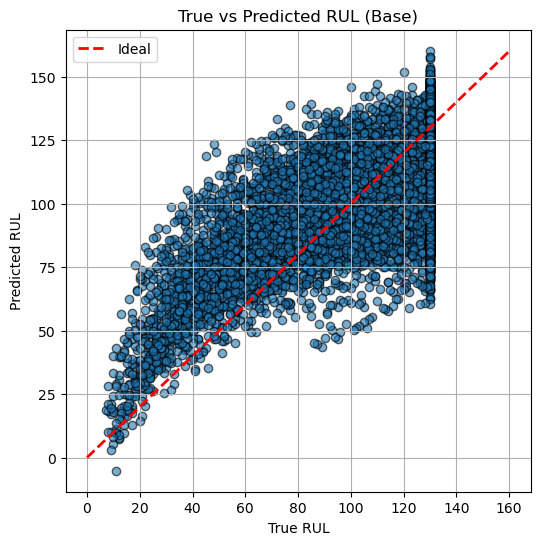

In [93]:
# plot_true_vs_pred

npz_path = ART_DIR / f"{DATASET.lower()}_seq{SEQ_LEN}.npz"

_, _, _, _, X_test, y_test = pp.load_preprocessed_data(str(npz_path))

X_test_base = pp.make_feature_vectors_from_windows(X_test, strategy="last")

y_pred_base = models["Base"].predict(X_test_base).ravel()

y_true = y_test

plot_true_vs_pred(y_true, y_pred_base, model_name="Base")

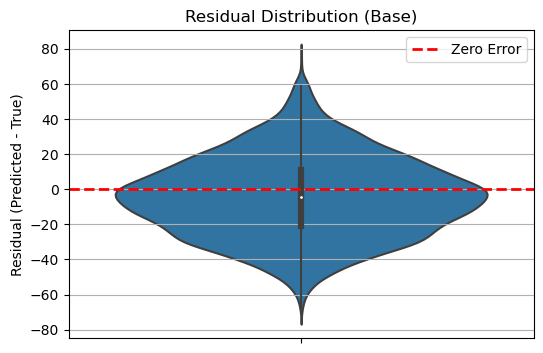

In [94]:
# Now plot residuals
plot_residuals(y_true, y_pred_base, model_name="Base", kind="violin")

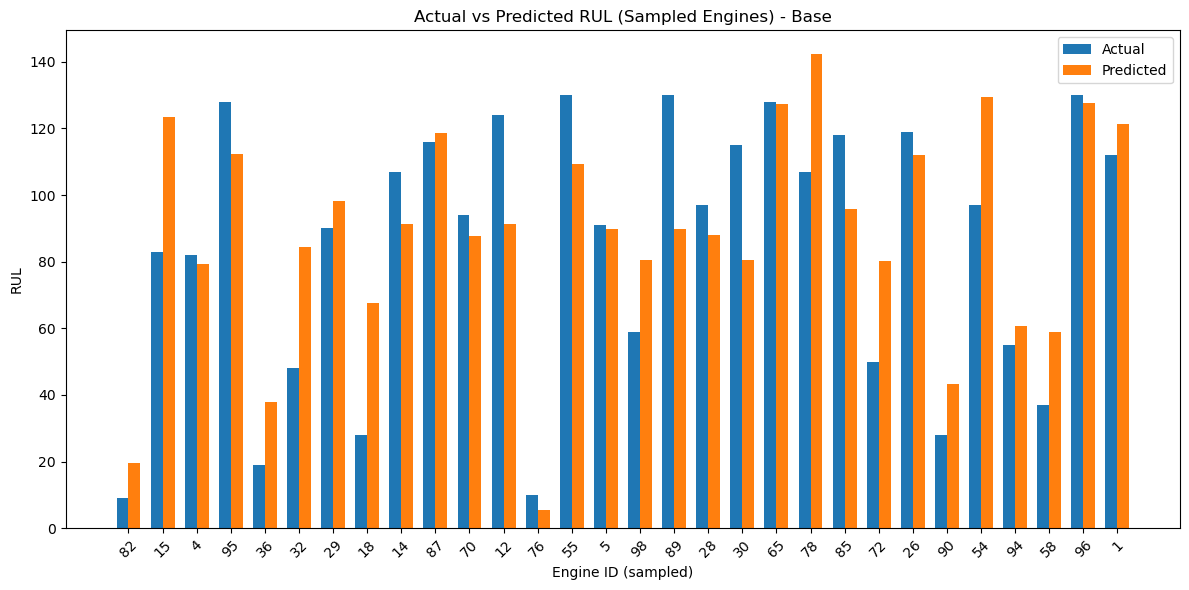

In [95]:
# Build unit IDs aligned to the windowed test data (X_test, y_test)
ids = []
for uid, grp in test_scaled.groupby("unit_number"):
    grp = grp.sort_values("time_in_cycles")
    n = len(grp) - SEQ_LEN + 1
    if n > 0:
        ids.extend([uid] * n)
unit_ids_aligned = np.array(ids)

# Now plot
plot_per_engine_bars(y_true, y_pred_base, unit_ids_aligned, model_name="Base")


# ================== End of Base TEST =====================

 # CNN Model Analysis

In [96]:
# CNN Prediction
from cnn_model import predict_cnn_model
y_pred_cnn = predict_cnn_model(models["CNN"], X_test)

319/319 [==============================] - 1s 2ms/step


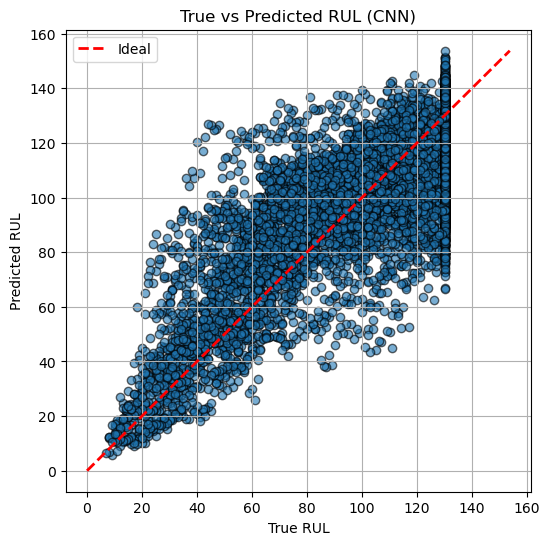

In [97]:
# plot_true_vs_pred

# can be rid, brought as don't want to run model build code again
npz_path = ART_DIR / f"{DATASET.lower()}_seq{SEQ_LEN}.npz"
_, _, _, _, X_test, y_test = pp.load_preprocessed_data(str(npz_path))

y_true = y_test

plot_true_vs_pred(y_true, y_pred_cnn, model_name="CNN")

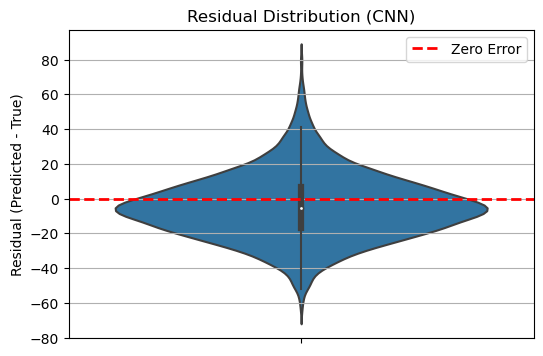

In [98]:
plot_residuals(y_true, y_pred_cnn, model_name="CNN", kind="violin")

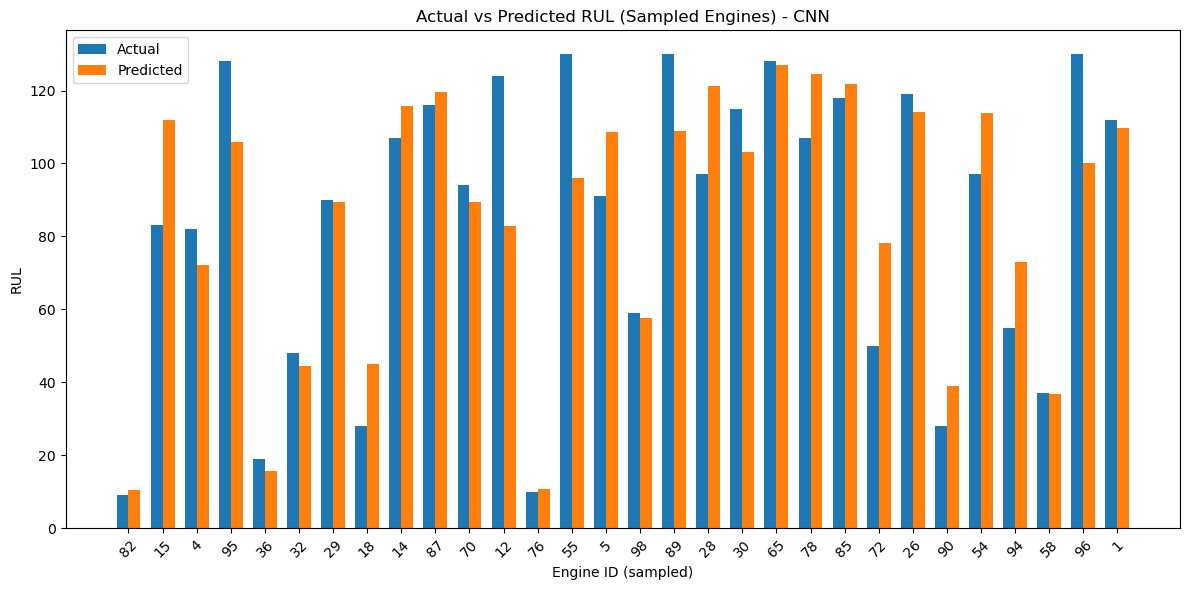

In [99]:
# Build unit IDs aligned to the windowed test data (X_test, y_test)
ids = []
for uid, grp in test_scaled.groupby("unit_number"):
    grp = grp.sort_values("time_in_cycles")
    n = len(grp) - SEQ_LEN + 1
    if n > 0:
        ids.extend([uid] * n)
unit_ids_aligned = np.array(ids)

# Now plot
plot_per_engine_bars(y_true, y_pred_cnn, unit_ids_aligned, model_name="CNN")

# ================== End of CNN TEST ===================

# LSTM ANALYSIS

In [100]:
# CNN Prediction
from lstm_model import predict_lstm_model
y_pred_lstm = predict_lstm_model(models["LSTM"], X_test)

319/319 [==============================] - 2s 6ms/step


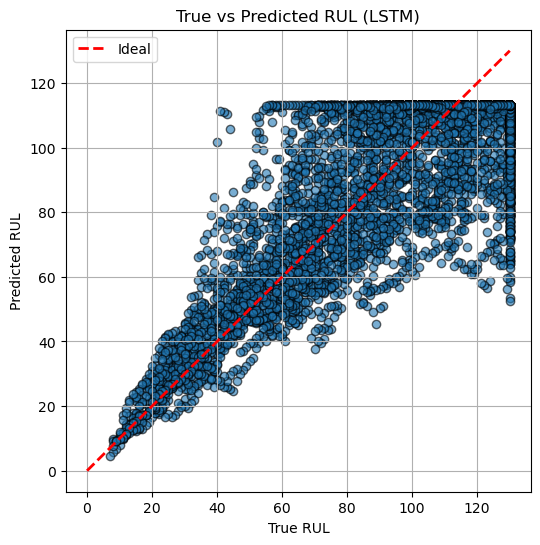

In [101]:
# plot_true_vs_pred

# can be rid, brought as don't want to run model build code again
npz_path = ART_DIR / f"{DATASET.lower()}_seq{SEQ_LEN}.npz"
_, _, _, _, X_test, y_test = pp.load_preprocessed_data(str(npz_path))

y_true = y_test
plot_true_vs_pred(y_true, y_pred_lstm, model_name="LSTM")

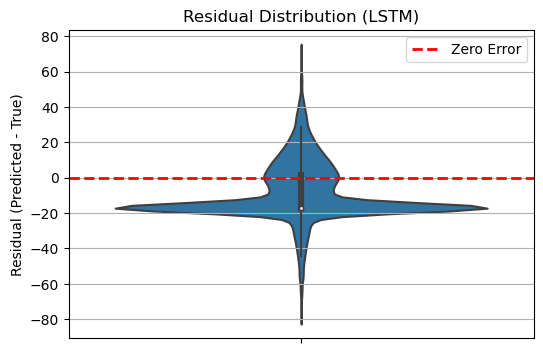

In [102]:
plot_residuals(y_true, y_pred_lstm, model_name="LSTM", kind="violin")

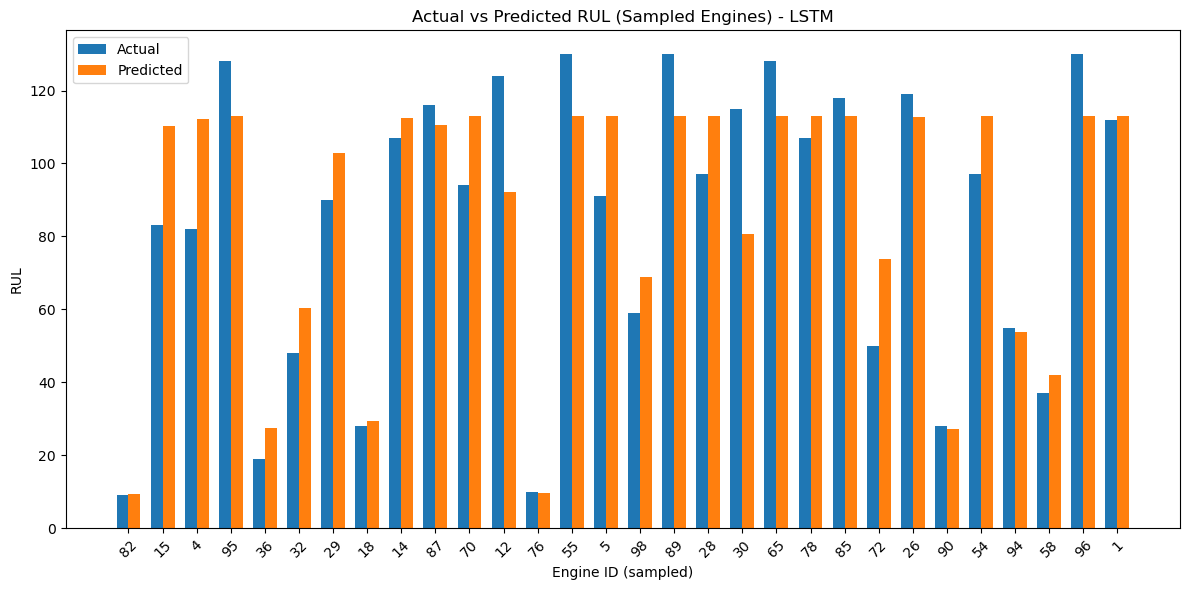

In [103]:
# Build unit IDs aligned to the windowed test data (X_test, y_test)
ids = []
for uid, grp in test_scaled.groupby("unit_number"):
    grp = grp.sort_values("time_in_cycles")
    n = len(grp) - SEQ_LEN + 1
    if n > 0:
        ids.extend([uid] * n)
unit_ids_aligned = np.array(ids)

# Now plot
plot_per_engine_bars(y_true, y_pred_lstm, unit_ids_aligned, model_name="LSTM")


# ================= End of LSTM TEST ==================

# LSTM_CNN Build Analysis

In [104]:
# CNN Prediction
from cnn_lstm_model import predict_cnn_lstm_model
y_pred_cnn_lstm = predict_cnn_lstm_model(models["CNN-LSTM"], X_test)

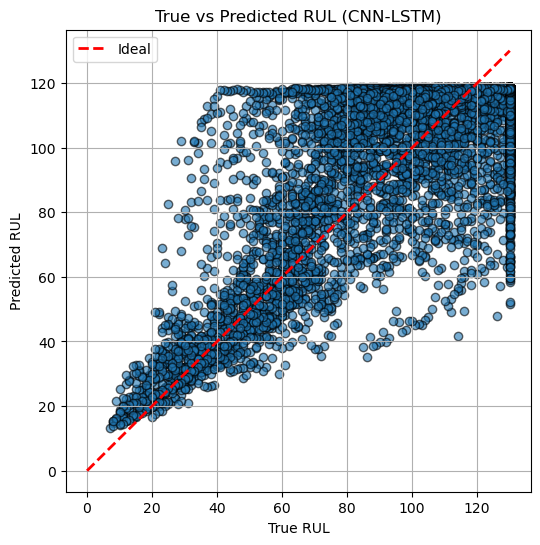

In [105]:
# plot_true_vs_pred

# can be rid, brought as don't want to run model build code again
npz_path = ART_DIR / f"{DATASET.lower()}_seq{SEQ_LEN}.npz"
_, _, _, _, X_test, y_test = pp.load_preprocessed_data(str(npz_path))

y_true = y_test
plot_true_vs_pred(y_true, y_pred_cnn_lstm, model_name="CNN-LSTM")

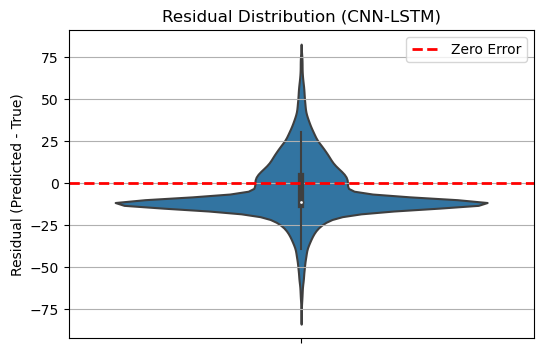

In [106]:
plot_residuals(y_true, y_pred_cnn_lstm, model_name="CNN-LSTM", kind="violin")

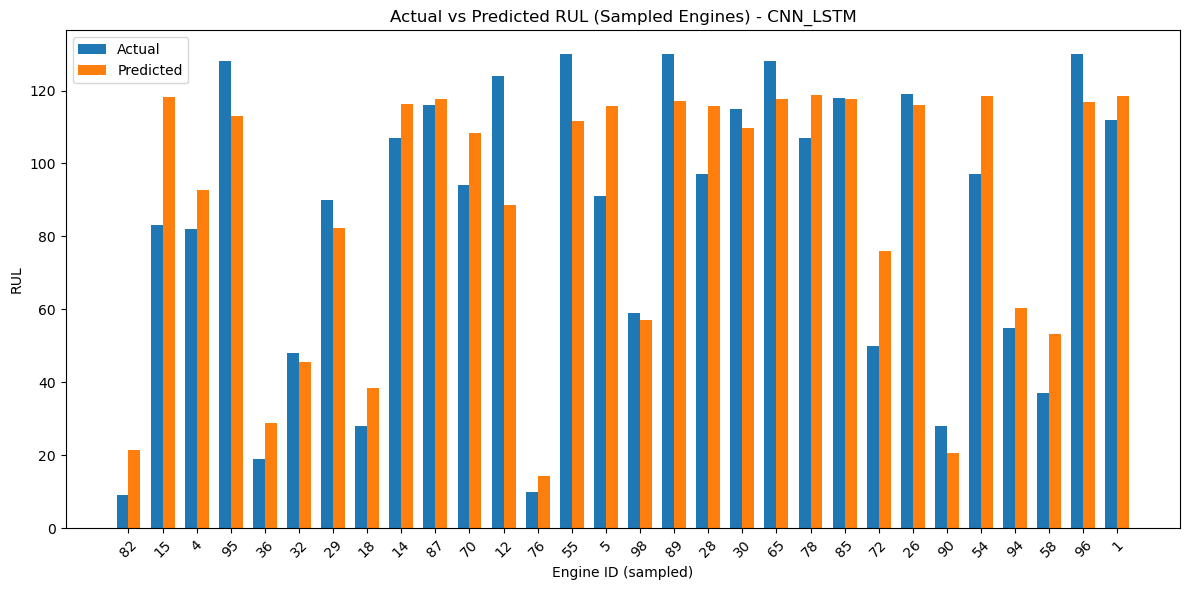

In [107]:
# Build unit IDs aligned to the windowed test data (X_test, y_test)
ids = []
for uid, grp in test_scaled.groupby("unit_number"):
    grp = grp.sort_values("time_in_cycles")
    n = len(grp) - SEQ_LEN + 1
    if n > 0:
        ids.extend([uid] * n)
unit_ids_aligned = np.array(ids)

# Now plot
plot_per_engine_bars(y_true, y_pred_cnn_lstm, unit_ids_aligned, model_name="CNN_LSTM")


# =========== End of CNN_LSTM TEST =================

# ============= Evaluation Section =====================

# ================ RMSE & MAE ======================

 ## base model 

In [108]:
from evaluator import evaluate_model

# load preprocessed test set
npz_path = ART_DIR / f"{DATASET.lower()}_seq{SEQ_LEN}.npz"
_, _, _, _, X_test, y_test = pp.load_preprocessed_data(str(npz_path))

# convert if using base model (needs 2D vectors)
X_test_feat = pp.make_feature_vectors_from_windows(X_test, strategy="last")

# load trained base model
model_path = ART_DIR / "models" / f"base_linear_{DATASET.lower()}_seq{SEQ_LEN}_last.joblib"
base_model = joblib.load(model_path)

# predict & evaluate
y_base_pred = base_model.predict(X_test_feat)
evaluate_model(y_test, y_base_pred, model_name="Base Linear Model")

Base Linear Model Evaluation:
  RMSE: 23.2810
  MAE : 18.8226


{'model': 'Base Linear Model', 'RMSE': 23.280973, 'MAE': 18.8226}

 ## CNN model 

In [109]:
# --- Predict & evaluate: CNN on FD001 test ---

from evaluator import evaluate_model

# 1) Load cached test windows
npz_path = ART_DIR / f"{DATASET.lower()}_seq{SEQ_LEN}.npz"
_, _, _, _, X_test, y_test = pp.load_preprocessed_data(str(npz_path))

# 2) Load saved CNN
cnn_path = ART_DIR / "models" / f"cnn_{DATASET.lower()}_seq{SEQ_LEN}.keras"
cnn_model = load_model(cnn_path)

# 3) Predict (CNN expects 3D windows)
y_cnn_pred = cnn_model.predict(X_test, verbose=0).squeeze()

# 4) Evaluate
evaluate_model(y_test, y_cnn_pred, model_name="CNN")

CNN Evaluation:
  RMSE: 19.5039
  MAE : 15.2885


{'model': 'CNN', 'RMSE': 19.503937, 'MAE': 15.288462}

 ## LSTM model 

In [110]:
# --- Predict & evaluate: LSTM on FD001 test ---

from evaluator import evaluate_model

# 1) Load cached test windows
npz_path = ART_DIR / f"{DATASET.lower()}_seq{SEQ_LEN}.npz"
_, _, _, _, X_test, y_test = pp.load_preprocessed_data(str(npz_path))

# 2) Load saved LSTM
lstm_path = ART_DIR / "models" / f"lstm_{DATASET.lower()}_seq{SEQ_LEN}.keras"
lstm_model = load_model(lstm_path)

# 3) Predict (LSTM expects 3D input)
y_lstm_pred = lstm_model.predict(X_test, verbose=0).squeeze()

# 4) Evaluate
evaluate_model(y_test, y_lstm_pred, model_name="LSTM")

LSTM Evaluation:
  RMSE: 18.6124
  MAE : 15.7869


{'model': 'LSTM', 'RMSE': 18.612432, 'MAE': 15.786917}

# CNN_LSTM model

In [111]:
# --- Predict & evaluate: LSTM on FD001 test ---

from evaluator import evaluate_model

# 1) Load cached test windows
npz_path = ART_DIR / f"{DATASET.lower()}_seq{SEQ_LEN}.npz"
_, _, _, _, X_test, y_test = pp.load_preprocessed_data(str(npz_path))

# 2) Load saved LSTM
lstm_path = ART_DIR / "models" / f"cnn_lstm_{DATASET.lower()}_seq{SEQ_LEN}.keras"
lstm_model = load_model(lstm_path)

# 3) Predict (LSTM expects 3D input)
y_cnn_lstm_pred = lstm_model.predict(X_test, verbose=0).squeeze()

# 4) Evaluate
evaluate_model(y_test, y_cnn_lstm_pred, model_name="CNN_LSTM")

CNN_LSTM Evaluation:
  RMSE: 19.1321
  MAE : 15.2806


{'model': 'CNN_LSTM', 'RMSE': 19.132107, 'MAE': 15.280622}

In [112]:
from evaluator import evaluate_model

# build tables

res_cnn     = evaluate_model(y_test, y_pred_cnn,     model_name="CNN")
res_lstm    = evaluate_model(y_test, y_lstm_pred,    model_name="LSTM")
res_cnnlstm = evaluate_model(y_test, y_cnn_lstm_pred, model_name="CNN-LSTM")
res_base    = evaluate_model(y_test, y_base_pred,    model_name="Base")

metrics = [res_cnn, res_lstm, res_cnnlstm, res_base]
metrics

CNN Evaluation:
  RMSE: 19.5039
  MAE : 15.2885
LSTM Evaluation:
  RMSE: 18.6124
  MAE : 15.7869
CNN-LSTM Evaluation:
  RMSE: 19.1321
  MAE : 15.2806
Base Evaluation:
  RMSE: 23.2810
  MAE : 18.8226


[{'model': 'CNN', 'RMSE': 19.503937, 'MAE': 15.288462},
 {'model': 'LSTM', 'RMSE': 18.612432, 'MAE': 15.786917},
 {'model': 'CNN-LSTM', 'RMSE': 19.132107, 'MAE': 15.280622},
 {'model': 'Base', 'RMSE': 23.280973, 'MAE': 18.8226}]

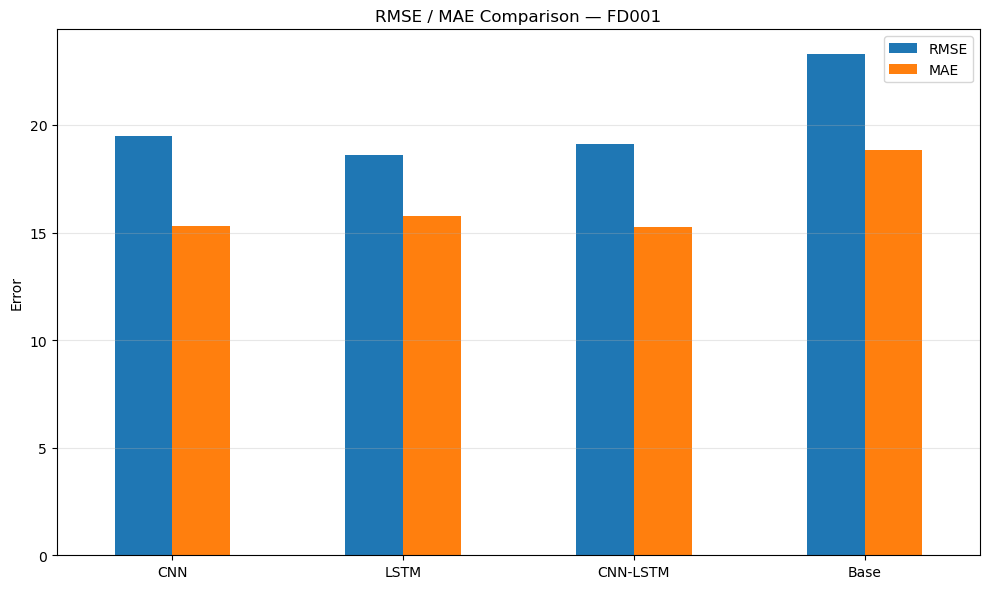

In [113]:
plot_metric_comparison(metrics, dataset_name=DATASET)

In [114]:
metrics_df = pd.DataFrame([res_cnn, res_lstm, res_cnnlstm, res_base])[
    ["model", "RMSE", "MAE"]
].rename(columns={"model":"Model"})

metrics_df = metrics_df.sort_values("RMSE").reset_index(drop=True).round(2)
display(metrics_df)

,Model,RMSE,MAE
0,LSTM,18.610001,15.79
1,CNN-LSTM,19.129999,15.28
2,CNN,19.500000,15.29
3,Base,23.280001,18.82


In [115]:
metrics_df.to_csv(ART_DIR / f"{DATASET.lower()}_metrics_seq{SEQ_LEN}.csv", index=False)